# **Knowledge Distillation**

### **Problem** : 

As we can see new trends in Deep learning are coming with really huge models. These models are really good with accuracy and predictions but have their cons too. Having good predictions is really great but whatif we cant deploy them into our end systems? No matter how good our model predicts, if we cant use in our business then its of no use.

Sometimes, we dont have enough compute power to make use of such huge models (like edge devices [ mobiles, Iot devices etc ]). Wouldnt it be great if we could somehow get a smaller model with almost same prediction power of large models? 

Yes we can, and this is where Knowledge distillation comes into picture.

* What is knowledge distillation?
 * its a method by which a large model transfers its knowledge to a smaller model.

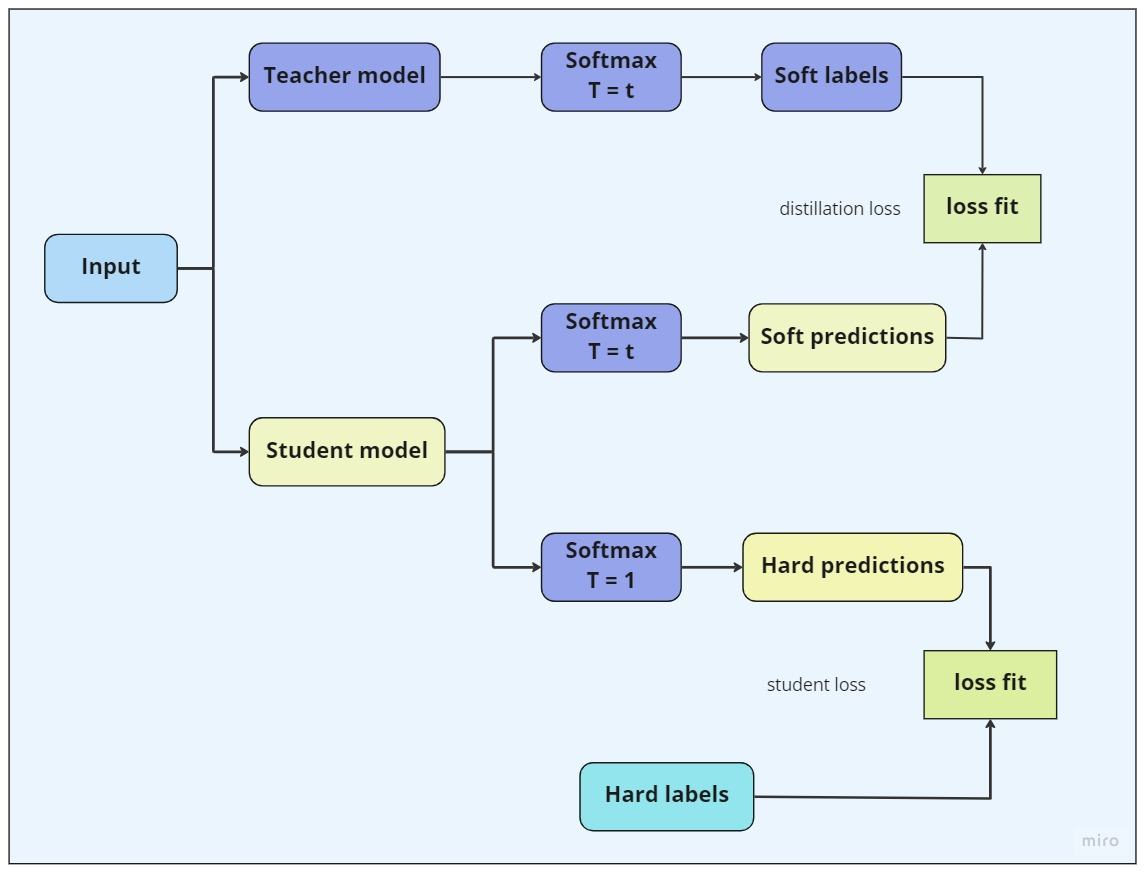


Here we have a main teacher model which is already pretained on some specific task. Then our student model will try to learn or predict what teacher model is trying to predict. So basically the teacher model will produce probabilities for some specific task. Our student model will try to predict those probabilities and then at the same time these probabilities will be used to give out actual outputs, which are required.

In [ ]:
import torch 

In [ ]:
# distillation loss

# its the sum of both the loss from teacher-student and student to hard labels
# our student model will be predicting the probabilities that our teachers model predicted.
# so it'll basically be a regression problem hence we'll use MSE loss

#       loss1 -- > Mean Squared loss [teacher_prediction, student_prediction]

# and then we student model will also be predicting the actual hard labels, which will basically be Cross entropy

#       loss2 -- > Cross Entropy loss [student_prediction, hard_label]


def KD_loss(y_pred_student, y_pred_teacher, y_true):
  """
  calculated the overall loss function which will be minimized
  input : teacher_predictions, student predictions, true_labels
  output : knowledge distillation loss
  
  """
  student_out = y_pred_student
  teacher_out = y_pred_teacher

  cross_entropy_loss = torch.nn.CrossEntropyLoss()
  mse_loss = torch.nn.MSELoss()

  # weighted sum of both the loss, where alpha is a hyperparameter
  loss = (1-alpha)*cross_entropy_loss(student_out, y_true) + (alpha * mse_loss(teacher_out, student_out))

  return loss



### **Training Teacher model** (Fine-tuning for main task)

In [ ]:
# evaluate teacher model

def evaluate_teacher(self, val_batch_size=16, verbose=True):
    """
    Function used for evaluating student
    :param max_seq_length (int): Maximum sequence length paramter for generating dataloaders
    :param val_batch_size (int): Batch size paramter for generating dataloaders
    :param verbose (bool): True if the accuracy needs to be printed else False
    """

    self.teacher_val_loader = self._get_teacher_dataloaders(
        val_batch_size, mode="validate"
    )

    self.teacher_model.to(self.device)
    self.teacher_model.eval()

    correct = 0
    length_of_dataset = len(self.teacher_val_loader.dataset)

    print("Evaluating teacher...")
    outputs = []

    for batch in self.teacher_val_loader:
        b_input_ids = batch[0].to(self.device)
        b_input_mask = batch[1].to(self.device)
        b_labels = batch[2].to(self.device)

        with torch.no_grad():
            (loss, logits) = self.teacher_model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to("cpu").numpy()

            # out = F.softmax(logits, dim=1)
            preds = np.argmax(logits, axis=1).flatten()
            labels = label_ids.flatten()

            correct += np.sum(preds == labels)
            outputs.append(preds)

    accuracy = correct / length_of_dataset
    if verbose:
        print("-" * 80)
        print(f"Accuracy: {accuracy}")

    return outputs, accuracy

In [ ]:
# this function will take args which will be used to training the main teacher model

def train_teacher(
        self,
        epochs=1,
        plot_losses=True,
        save_model=True,
        save_model_pth="./models/teacher.pt",
        train_batch_size=16,
        batch_print_freq=40,
        val_batch_size=16,
    ):
        """
        Function that will be training the teacher
        :param epochs (int): Number of epochs you want to train the teacher
        :param plot_losses (bool): True if you want to plot the losses
        :param save_model (bool): True if you want to save the teacher model
        :param save_model_pth (str): Path where you want to store the teacher model
        :param train_batch_size (int): Batch size paramter for generating dataloaders
        :param batch_print_freq (int): Frequency at which batch number needs to be printed per epoch
        """
        self.teacher_train_loader = self._get_teacher_dataloaders(
            train_batch_size, mode="train"
        )

        self.teacher_model.to(self.device)
        self.teacher_model.train()

        # training_stats = []
        loss_arr = []

        length_of_dataset = len(self.teacher_train_loader.dataset)
        best_acc = 0.0
        self.best_teacher_model_weights = deepcopy(self.teacher_model.state_dict())

        print("Training Teacher... ")

        for ep in range(epochs):
            print("")
            print("======== Epoch {:} / {:} ========".format(ep + 1, epochs))

            epoch_loss = 0.0
            correct = 0

            for step, batch in enumerate(self.teacher_train_loader):
                if step % (batch_print_freq) == 0 and not step == 0:
                    print("  Batch {:>5,}  of  {:>5,}.".format(step, len(self.teacher_train_loader)))

                b_input_ids = batch[0].to(self.device)
                b_input_mask = batch[1].to(self.device)
                b_labels = batch[2].to(self.device)

                self.optimizer_teacher.zero_grad()

                loss, logits = self.teacher_model(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels,
                )

                epoch_loss += loss.item()                 

                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to("cpu").numpy()
                preds = np.argmax(logits, axis=1).flatten()
                labels = label_ids.flatten()
                correct += np.sum(preds == labels)

                loss.backward()

                self.optimizer_teacher.step()

            epoch_acc = correct / length_of_dataset
            print(f"Loss: {epoch_loss} | Accuracy: {epoch_acc}")

            _, epoch_val_acc = self.evaluate_teacher(val_batch_size)

            if epoch_val_acc > best_acc:
                best_acc = epoch_val_acc
                # instead of saving models over and over again as we get high accuracy, its better to replace model weights with better model weights
                self.best_teacher_model_weights = deepcopy(
                    self.teacher_model.state_dict()
                )

            if self.log:
                self.writer.add_scalar("Training loss/Teacher", epoch_loss, epochs)
                self.writer.add_scalar("Training accuracy/Teacher", epoch_acc, epochs)
                self.writer.add_scalar("Validation accuracy/Teacher", epoch_val_acc, epochs)

            loss_arr.append(epoch_loss)

        self.teacher_model.load_state_dict(self.best_teacher_model_weights)

        if save_model:
            torch.save(self.teacher_model.state_dict(), save_model_pth)

        if plot_losses:
            plt.plot(loss_arr)


### **Train Student model**

In [ ]:
 def evaluate_student(self, verbose=True):
        """
        Function used for evaluating student
        :param verbose (bool): True if the accuracy needs to be printed else False
        """

        self.student_model.eval()
        self.student_model.to(self.device)
        length_of_dataset = len(self.val_loader.dataset)
        correct = 0
        outputs = []

        with torch.no_grad():
            for data, data_len, target in self.val_loader:
                data = data.to(self.device)
                data_len = data_len.to(self.device)
                target = target.to(self.device)
                output = self.student_model(data, data_len).squeeze(1)
                outputs.append(output)

                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / length_of_dataset
        if verbose:
            print("-" * 80)
            print(f"Accuracy: {accuracy}")

        return outputs, accuracy

In [ ]:
  def train_student(
        self,
        epochs=10,
        plot_losses=True,
        save_model=True,
        save_model_pth="./models/student.pth",
    ):
        """
        Function that will be training the student
        :param epochs (int): Number of epochs you want to train the teacher
        :param plot_losses (bool): True if you want to plot the losses
        :param save_model (bool): True if you want to save the student model
        :param save_model_pth (str): Path where you want to save the student model
        """

        self.teacher_distill_loader = self._get_teacher_dataloaders(
            batch_size=self.train_loader.batch_size, mode="distill"
        )

        y_pred_teacher = []

        print("Obtaining teacher predictions...")
        self.teacher_model.eval()
        self.teacher_model.to(self.device)

        #********************* First get outputs from teacher model ***********************
        for batch in self.teacher_distill_loader:
            b_input_ids = batch[0].to(self.device)
            b_input_mask = batch[1].to(self.device)
            b_labels = batch[2].to(self.device)

            with torch.no_grad():
                (loss, logits) = self.teacher_model(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels,
                )

                logits = logits.detach().cpu().numpy()

                y_pred_teacher.append(logits)

        # ******************* now Train student model ************************************

        # we use teacher model outputs[probabilities] as target for student model
        # which will learn to predict those probabilities hence we can formulate it as Regression problem

        self.student_model.train()

        loss_arr = []
        length_of_dataset = len(self.train_loader.dataset)
        best_acc = 0.0
        self.best_student_model_weights = deepcopy(self.student_model.state_dict())
        self.student_model.to(self.device)

        print("\nTraining student...")

        for ep in range(epochs):
            print("")
            print("======== Epoch {:} / {:} ========".format(ep + 1, epochs))

            epoch_loss = 0.0
            correct = 0

            # our_teacher pred are stored as list of list where each list is 1-batch output of teacher model
            for (data, data_len, label), bert_prob in zip(self.train_loader, y_pred_teacher):

                data = data.to(self.device)
                data_len = data_len.to(self.device)
                label = label.to(self.device)

                bert_prob = torch.tensor(bert_prob, dtype=torch.float)
                teacher_out = bert_prob.to(self.device)

                self.optimizer_student.zero_grad()

                student_out = self.student_model(data, data_len).squeeze(1)   # outputs are probabilities/regression outputs

                loss = self.calculate_kd_loss(student_out, teacher_out, label)

                pred = student_out.argmax(dim=1, keepdim=True)
                correct += pred.eq(label.view_as(pred)).sum().item()

                loss.backward()

                # ##For preventing exploding gradients
                # torch.nn.utils.clip_grad_norm_(self.student_model.parameters(), 1.0)

                self.optimizer_student.step()

                epoch_loss += loss

            epoch_acc = correct / length_of_dataset
            print(f"Loss: {epoch_loss} | Accuracy: {epoch_acc}")

            _, epoch_val_acc = self.evaluate_student()
            if epoch_val_acc > best_acc:
                best_acc = epoch_val_acc
                self.best_student_model_weights = deepcopy(self.student_model.state_dict())

            if self.log:
                self.writer.add_scalar("Training loss/Student", epoch_loss, epochs)
                self.writer.add_scalar("Training accuracy/Student", epoch_acc, epochs)
                self.writer.add_scalar(
                    "Validation accuracy/Student", epoch_val_acc, epochs
                )

            loss_arr.append(epoch_loss)
            print(f"Epoch: {ep+1}, Loss: {epoch_loss}, Accuracy: {epoch_acc}")

        self.student_model.load_state_dict(self.best_student_model_weights)

        if save_model:
            torch.save(self.student_model.state_dict(), save_model_pth)

        if plot_losses:
            plt.plot(loss_arr)

  